## Gesture Recognition - Deep Learning Assignment

#### Developed by:
##### 1. Yash Raj Sinha
##### 2. Anirudhya Bhattacharya



### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Importing the necessary libraries

import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.random.set_seed

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# importing some other libraries which will be needed for model building.

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

In [5]:
project_folder='/home/datasets/Project_data'

##### Plotting

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(history.history['val_categorical_accuracy']))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

We will create a class which will contain modules for following purposes:
- Initialising the path where project data resides.
- Initialising the image properties
- Initialising the batch size, frames to sample and the no. of epochs
- The generator function [MOST IMPORTANT PART] 
- Performing image reading, resizing and normalizing.
- Train and save the model at each epoch.


In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialising the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment):
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized= resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized = resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                    #batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    #batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    #batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = 'epoch')
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]
        
        
         

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                          callbacks=callbacks_list, validation_data=val_generator, 
                          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        K.clear_session()
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

##### Sample Cropping

Source path =  /home/datasets/Project_data/val ; batch size = 3


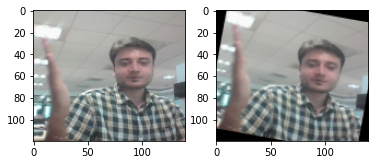

In [9]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=140)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

## Experimenting with Image resolution, number of frames to use and batch_size

Lets trade-off between these parameters.<br/>
Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6757 - categorical_accuracy: 0.3831Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 2.06403, saving model to model_init_2021-10-2416_58_17.644378/model-00001-1.67571-0.38311-2.06403-0.16000.h5
23/23 [==============================] - 103s 4s/step - loss: 1.6757 - categorical_accuracy: 0.3831 - val_loss: 2.0640 - val_categorical_accuracy: 0.1600
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0647 - categorical_accuracy: 0.5701
Epoch 00002: val_loss did not improve from 2.06403
23/23 [==============================] - 99s 4s/step - loss: 1.0647 - categorical_accuracy: 0.5701 - val_loss: 3.7622 - val_categorical_accuracy: 0.1500


In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.7412 - categorical_accuracy: 0.3831Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 3.17295, saving model to model_init_2021-10-2417_01_48.673253/model-00001-1.74124-0.38311-3.17295-0.16000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.7412 - categorical_accuracy: 0.3831 - val_loss: 3.1730 - val_categorical_accuracy: 0.1600
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.1232 - categorical_accuracy: 0.5566
Epoch 00002: val_loss did not improve from 3.17295
34/34 [==============================] - 145s 4s/step - loss: 1.1232 - categorical_accuracy: 0.5566 - val_loss: 5.3794 - val_categorical_accuracy: 0.1400


In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5950 - categorical_accuracy: 0.4510Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 4.89903, saving model to model_init_2021-10-2417_06_44.517325/model-00001-1.59504-0.45098-4.89903-0.16000.h5
45/45 [==============================] - 171s 4s/step - loss: 1.5950 - categorical_accuracy: 0.4510 - val_loss: 4.8990 - val_categorical_accuracy: 0.1600
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0616 - categorical_accuracy: 0.5867
Epoch 00002: val_loss did not improve from 4.89903
45/45 [==============================] - 175s 4s/step - loss: 1.0616 - categorical_accuracy: 0.5867 - val_loss: 6.5691 - val_categorical_accuracy: 0.1600


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/2


ResourceExhaustedError:  OOM when allocating tensor with shape[30,16,16,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-8-6382a1e642e1>:129) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_11914]

Function call stack:
train_function


- As we see from the above experiments **"image resolution"** and **batch_size** have more impact on training time than **number of frames** in sequence.
- We can consider the Batch Size around 20-30
- We can consider the number of frames as 30
- We will change the resolution 160x160 and 120x120 according the model performance


## Model 1
- Batch Size = 30 
- No. of Epochs = 15
- Image Size = 160x160
- filtersize=(3,3,3)

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.15):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 80, 80, 32)   

In [16]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.4163 - categorical_accuracy: 0.4721Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.59186, saving model to model_init_2021-10-2508_32_26.887218/model-00001-1.41628-0.47210-1.59186-0.27000.h5
23/23 [==============================] - 182s 8s/step - loss: 1.4163 - categorical_accuracy: 0.4721 - val_loss: 1.5919 - val_categorical_accuracy: 0.2700
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 0.8585 - categorical_accuracy: 0.6878
Epoch 00002: val_loss did not improve from 1.59186
23/23 [==============================] - 184s 8s/step - loss: 0.8585 - categorical_accuracy: 0.6878 - val_loss: 2.0253 - val_categorical_accuracy: 0.1700
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.4839 - categorical_accuracy: 0.8371
Epoch 00003: val_

Max. Training Accuracy 0.9894419312477112
Max. Validaiton Accuracy 0.27000001072883606


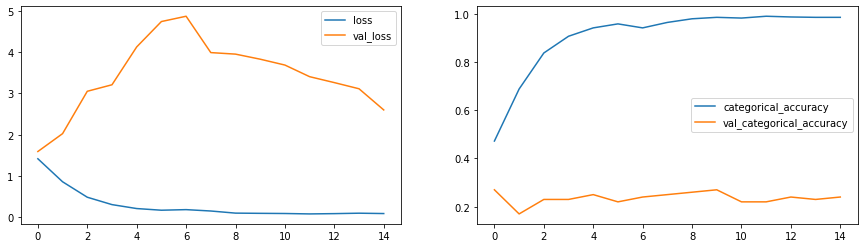

In [17]:
plot(history_model1)

**Model is clearly overfitting. There is a huge difference between Training and validation accuracy.**

## Model 2

**Goal:** To handle the overfitting issue.

- Adding dropout layers as a form of regularization
- Including Data Augmentation
- Decreasing Batch Size to 20
- Increasing No. of Epochs to 25
- changing filtersize to (2,2,2)

In [11]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  400       
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 80, 80, 32)   

In [12]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3433781
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7400 - categorical_accuracy: 0.4223Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 6.12091, saving model to model_init_2021-10-2513_32_17.011674/model-00001-1.74001-0.42232-6.12091-0.16000.h5
34/34 [==============================] - 242s 7s/step - loss: 1.7400 - categorical_accuracy: 0.4223 - val_loss: 6.1209 - val_categorical_accuracy: 0.1600
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2151 - categorical_accuracy: 0.5807
Epoch 00002: val_loss did not improve from 6.12091
34/34 [==============================] - 246s 7s/step - loss: 1.2151 - categorical_accuracy: 0.5807 - val_loss: 9.7846 - val_categorical_accuracy: 0.1900
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9057 - categorical_accuracy: 0.6810
Epoch 00003: val_

Max. Training Accuracy 0.9253393411636353
Max. Validaiton Accuracy 0.9100000262260437


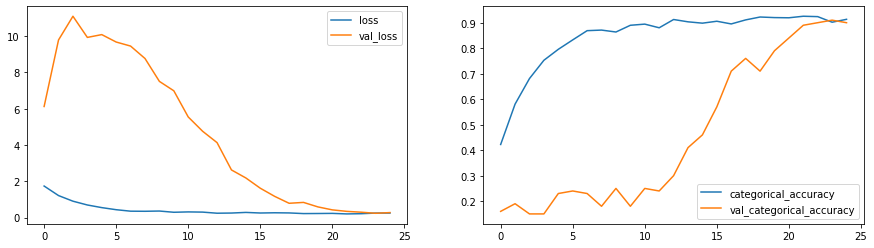

In [13]:
plot(history_model2)

We can say the over fitting issue has now resolved after augmenting data and adding dropout.

- Best weights save automatically at Epoch 6. The validation accuracy of 91% and training accuracy of 92%.
- total number of trainable parameters are 3,433,781. Now we will try to reduce that.

Next we will try to reduce the filter size and image resolution and see if we can get better results. Moreover since we see oscillations in loss, let's try lowering the learning rate to 0.0002.

Lowering the learning rate means weights will get updated slowly, so we will have to increase number of epochs.

## Model 3 

**Goal:** To control number of parameter and oscillation in loss

- Adding dropout layers as a form of regularization
- Lowering image res to 120 x  120
- Lowering sample size to 18
- Keeping Batch Size to 20
- Increasing No. of Epochs to 30
- Changing filtersize to (3,3,3)
- Lowering the learning rate to 0.0002

In [24]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 32)    

In [27]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.0121 - categorical_accuracy: 0.3673Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.75176, saving model to model_init_2021-10-2515_33_59.242394/model-00001-2.01211-0.36727-1.75176-0.16000.h5
23/23 [==============================] - 173s 8s/step - loss: 2.0121 - categorical_accuracy: 0.3673 - val_loss: 1.7518 - val_categorical_accuracy: 0.1600
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3974 - categorical_accuracy: 0.5053
Epoch 00002: val_loss did not improve from 1.75176
23/23 [==============================] - 171s 7s/step - loss: 1.3974 - categorical_accuracy: 0.5053 - val_loss: 2.4262 - val_categorical_accuracy: 0.1800
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2304 - categorical_accuracy: 0.5807
Epoch 00003: val_

Max. Training Accuracy 0.7292609214782715
Max. Validaiton Accuracy 0.6600000262260437


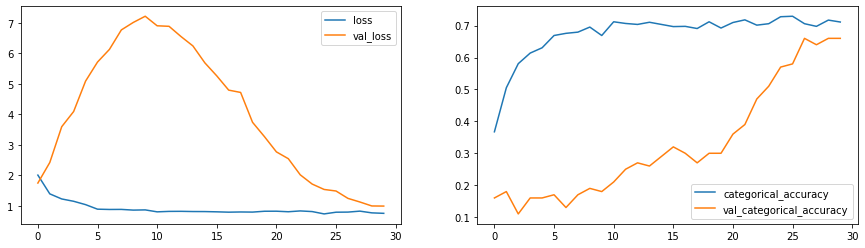

In [28]:
plot(history_model3)

#####  Validaiton Accuracy did not improve from 0.91.

But we were able to reduce the parameter size by half the earlier model.<br/>
Let's try adding more layers

## Model 4

**Goal:** To increase accuracy further.
- Image res 120x120
- No of frames 16
- Batch Size 20
- same number of epochs
- Adding more layer.

In [8]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)    

In [11]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9420 - categorical_accuracy: 0.3914Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.10666, saving model to model_init_2021-10-2606_49_12.638039/model-00001-1.94200-0.39140-2.10666-0.18000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.9420 - categorical_accuracy: 0.3914 - val_loss: 2.1067 - val_categorical_accuracy: 0.1800
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6451 - categorical_accuracy: 0.4691
Epoch 00002: val_loss improved from 2.10666 to 2.07852, saving model to model_init_2021-10-2606_49_12.638039/model-00002-1.64511-0.46908-2.07852-0.17000.h5
34/34 [==============================] - 165s 5s/step - loss: 1.6451 - categorical_accuracy: 0.4691 - val_loss: 2.0785 - val_categorical_accuracy: 0.1700
Epoch 3/30
34/34 [

Max. Training Accuracy 0.9517345428466797
Max. Validaiton Accuracy 0.9100000262260437


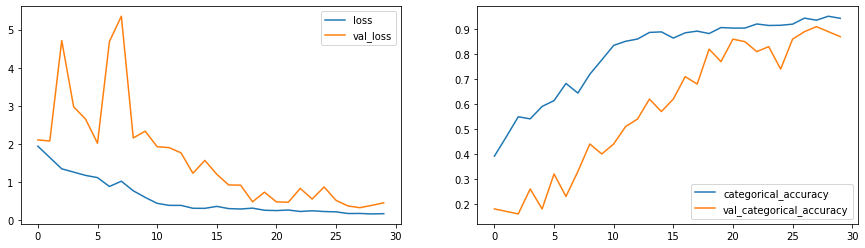

In [12]:
plot(history_model4)

With more layers we dont see much performance improvement.<br/>
We get a best validation accuracy of 91% which is same as Model-2.But there is little bit of overfitting. <br/>
Let's try adding dropouts at the convolution layers<br/>

## Model 5 
- Adding dropout at convolution layers

In [15]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0

In [17]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7987 - categorical_accuracy: 0.3725Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 3.04783, saving model to model_init_2021-10-2608_23_52.458285/model-00001-1.79871-0.37255-3.04783-0.21000.h5
34/34 [==============================] - 187s 5s/step - loss: 1.7987 - categorical_accuracy: 0.3725 - val_loss: 3.0478 - val_categorical_accuracy: 0.2100
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4150 - categorical_accuracy: 0.4585
Epoch 00002: val_loss improved from 3.04783 to 2.15435, saving model to model_init_2021-10-2608_23_52.458285/model-00002-1.41501-0.45852-2.15435-0.13000.h5
34/34 [==============================] - 182s 5s/step - loss: 1.4150 - categorical_accuracy: 0.4585 - val_loss: 2.1544 - val_categorical_accuracy: 0.1300
Epoch 3/30
34/34 [

Max. Training Accuracy 0.9012066125869751
Max. Validaiton Accuracy 0.6399999856948853


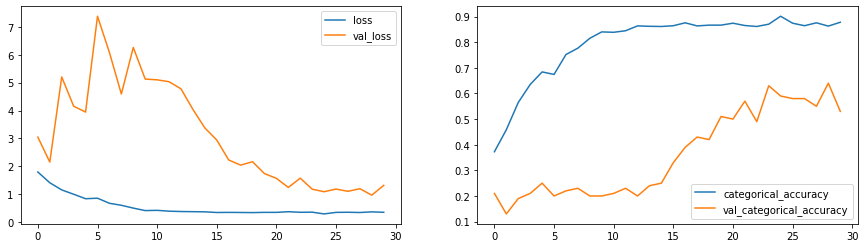

In [18]:
plot(history_model5)

 From the plots it looks like the model is Overfitting again!!<br/>
 Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [12]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 32)    

In [14]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 909637
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.5513 - categorical_accuracy: 0.4344Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.48673, saving model to model_init_2021-10-2611_19_15.672886/model-00001-1.55127-0.43439-2.48673-0.16000.h5
34/34 [==============================] - 168s 5s/step - loss: 1.5513 - categorical_accuracy: 0.4344 - val_loss: 2.4867 - val_categorical_accuracy: 0.1600
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0168 - categorical_accuracy: 0.6139
Epoch 00002: val_loss did not improve from 2.48673
34/34 [==============================] - 171s 5s/step - loss: 1.0168 - categorical_accuracy: 0.6139 - val_loss: 3.0286 - val_categorical_accuracy: 0.1500
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.7148 - categorical_accuracy: 0.7202
Epoch 00003: val_l

Max. Training Accuracy 0.9509803652763367
Max. Validaiton Accuracy 0.9399999976158142


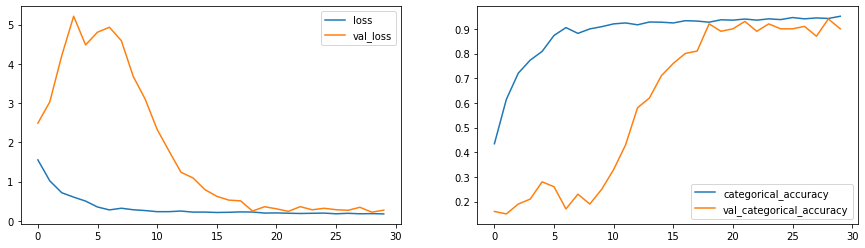

In [16]:
plot(history_model6)

###### For the above model, we get the best validation accuracy of almost 94% and training accuracy of 95%
- This is the best accuracy we have got so far.
- This model has the lowest number of parameter when compared with Model-2 and Model-4. As a result it will have the lowest memory footprint and require less computational power.

## Model 7 - Reducing the number of parameters further

In [22]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 32)    

In [24]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.4948 - categorical_accuracy: 0.4253Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.73705, saving model to model_init_2021-10-2613_14_34.389929/model-00001-1.49480-0.42534-1.73705-0.26000.h5
34/34 [==============================] - 180s 5s/step - loss: 1.4948 - categorical_accuracy: 0.4253 - val_loss: 1.7370 - val_categorical_accuracy: 0.2600
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0337 - categorical_accuracy: 0.6003
Epoch 00002: val_loss did not improve from 1.73705
34/34 [==============================] - 189s 6s/step - loss: 1.0337 - categorical_accuracy: 0.6003 - val_loss: 2.2017 - val_categorical_accuracy: 0.2200
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.8881 - categorical_accuracy: 0.6508
Epoch 00003: val_l

Max. Training Accuracy 0.9381598830223083
Max. Validaiton Accuracy 0.9100000262260437


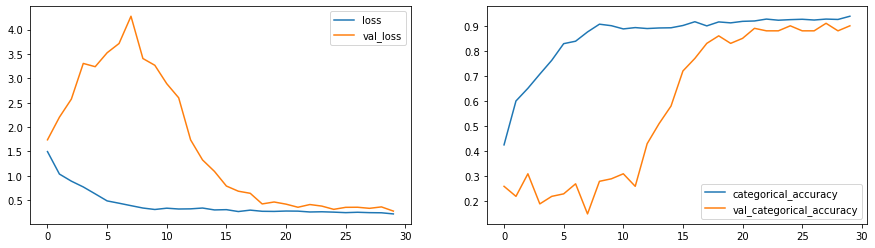

In [25]:
plot(history_model7)

## For the above model:
- We have been able to minimize the number of parameters and also get a decent validation accuracy of 91%.
- There is a little bit of overfitting as the training accuracy is almost 94%

## Model 8

Goal: Minimize the minor overfitting of the last model.

- Lowering the learning rate from default(0.001) to 0.0005
- Increasing the dropout from 0.25 to 0.5

In [27]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.5)
conv_3d7_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

In [29]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.2321 - categorical_accuracy: 0.2888Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.98623, saving model to model_init_2021-10-2615_24_24.264995/model-00001-2.23214-0.28884-1.98623-0.16000.h5
34/34 [==============================] - 207s 6s/step - loss: 2.2321 - categorical_accuracy: 0.2888 - val_loss: 1.9862 - val_categorical_accuracy: 0.1600
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.7703 - categorical_accuracy: 0.3808
Epoch 00002: val_loss did not improve from 1.98623
34/34 [==============================] - 207s 6s/step - loss: 1.7703 - categorical_accuracy: 0.3808 - val_loss: 3.1138 - val_categorical_accuracy: 0.1400
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.5677 - categorical_accuracy: 0.4427
Epoch 00003: val_l

Max. Training Accuracy 0.6636500954627991
Max. Validaiton Accuracy 0.8600000143051147


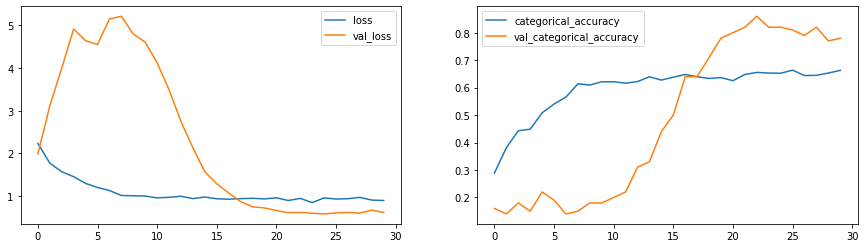

In [30]:
plot(history_model7)

## Model 9 - CNN- LSTM Model

In [42]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
        #model.add(TimeDistributed(BatchNormalization()))
        #model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 20, 30, 30, 64)   

In [45]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5685 - categorical_accuracy: 0.2971Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.61876, saving model to model_init_2021-10-2510_45_42.226002/model-00001-1.56847-0.29713-1.61876-0.20000.h5
34/34 [==============================] - 196s 6s/step - loss: 1.5685 - categorical_accuracy: 0.2971 - val_loss: 1.6188 - val_categorical_accuracy: 0.2000
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3476 - categorical_accuracy: 0.4517
Epoch 00002: val_loss did not improve from 1.61876
34/34 [==============================] - 195s 6s/step - loss: 1.3476 - categorical_accuracy: 0.4517 - val_loss: 1.6502 - val_categorical_accuracy: 0.2400
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2162 - categorical_accuracy: 0.5234
Epoch 00003: val_

Max. Training Accuracy 0.7164404392242432
Max. Validaiton Accuracy 0.6800000071525574


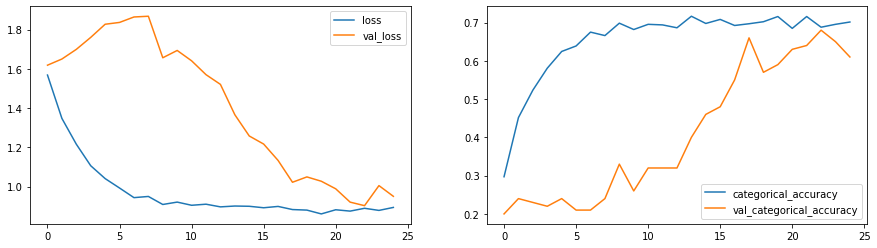

In [46]:
plot(history_model9)

##### For CNN - LSTM model we get a best training accuracy of 71% and validation accuracy of 68%

So it didnt outperform model-6 in terms of no. of parameters or performance.

## Model 10 - Let us bring in Transfer Learning now

- Bringing in Transfer Learning now.
__(Optional)__

**Note:**
- Importing the MobileNet model due to it's lightweight architecture and high speed performance as compared to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc.
- Also, we are now also running on low account balance in the jarvislabs.ai platform.

In [9]:
from tensorflow.keras.applications import mobilenet

In [11]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [13]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3381 - categorical_accuracy: 0.4502Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 0.96892, saving model to model_init_2021-10-2709_12_12.187615/model-00001-1.33814-0.45023-0.96892-0.63000.h5
133/133 [==============================] - 166s 1s/step - loss: 1.3381 - categorical_accuracy: 0.4502 - val_loss: 0.9689 - val_categorical_accuracy: 0.6300
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7736 - categorical_accuracy: 0.7134
Epoch 00002: val_loss improved from 0.96892 to 0.69754, saving model to model_init_2021-10-2709_12_12.187615/model-00002-0.77364-0.71342-0.69754-0.76000.h5
133/133 [==============================] - 197s 1s/step - loss: 0.7736 - categorical_accuracy: 0.7134 - val_loss: 0.6975 - val_categorical_accuracy: 0.7600
Epoch 3/20
1

Max. Training Accuracy 0.9856711626052856
Max. Validaiton Accuracy 0.8399999737739563


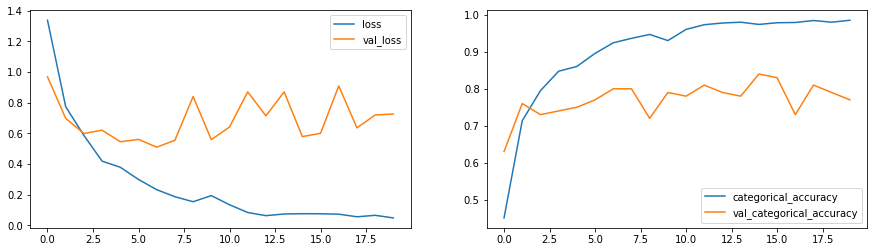

In [14]:
plot(history_model16)

**We did not train the mobilenet weights and as a result we see validation accuracy is very poor.**
**Let's train them as well and observe if there is performance improvement**

## Model 11 - Transfer Learning with GRU and training all weights
__(Optional)__

In [18]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

class RNNCNN_TL2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [19]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 5, 5, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 4096)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               1622784   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [20]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model11=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 4872901
Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.9713 - categorical_accuracy: 0.6342Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 0.82111, saving model to model_init_2021-10-2710_20_00.261909/model-00001-0.97134-0.63424-0.82111-0.69000.h5
133/133 [==============================] - 214s 2s/step - loss: 0.9713 - categorical_accuracy: 0.6342 - val_loss: 0.8211 - val_categorical_accuracy: 0.6900
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.5375 - categorical_accuracy: 0.7866
Epoch 00002: val_loss improved from 0.82111 to 0.44470, saving model to model_init_2021-10-2710_20_00.261909/model-00002-0.53755-0.78658-0.44470-0.85000.h5
133/133 [==============================] - 214s 2s/step - loss: 0.5375 - categorical_accuracy: 0.7866 - val_loss: 0.4447 - val_categorical_accuracy: 0.8500
Epoch 3/20
1

Max. Training Accuracy 0.9901960492134094
Max. Validaiton Accuracy 0.9800000190734863


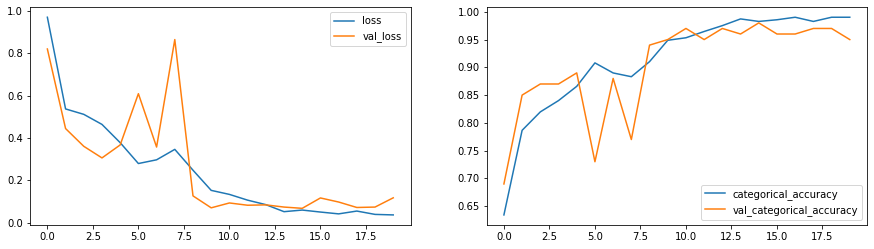

In [21]:
plot(history_model11)

**We can clearly see the effects of training the weights is outstanding! 99% Training accuracy and 98% validation accuracy**

## After doing all the experiments, we finalized Model 6.

**Reason:**

- Training Accuracy: 94%, Validation Accuracy: 94%.

- Number of Parameters (909,637) less according to other models’ performance

- Learning rate gradually decreasing after some Epochs


The best weights of Model 6: model-00029-0.18226-0.94193-0.21954-0.94000.h5 (10.5 MB). we considered this weight for model testing, Let's have look at the performance below


# Loading model and Testing

In [9]:
import time
from tensorflow.keras.models import load_model
model = load_model('model-00029-0.18226-0.94193-0.21954-0.94000.h5')

In [14]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [15]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 1 1 3 1 1 0 2 2 1 0 3 4 2 4 1 0 3 4 1]
